In [1]:
import numpy as np
import os
import sys
import random
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

from factor_vae import FactorVAEDSprites, Discriminator
from datasets import train_test_random_split, load_dsprites, CustomDSpritesDatasetFactorVAE
from train import train_factor_vae, test_factor_vae
from entanglement_metric import entanglement_metric_factor_vae, entanglement_metric_beta_vae
from utils import latent_transversal
from beta_vae import Classifier

In [2]:
dataset = load_dsprites("../datasets/dsprites.npz",False)

In [3]:
data_size = 10000
data_ = CustomDSpritesDatasetFactorVAE(dataset,data_size)

In [4]:
def plot_loss(loss_list, title):
    plt.plot(np.arange(1,len(loss_list)+1, 1), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training "+title)
    plt.show()

In [15]:
model0 = torch.load('trained_models/betavae_beta4_e100_alldata.dat', map_location=torch.device('cpu'))
model1 = torch.load('trained_models/betavae_beta1_e40_alldata.dat', map_location=torch.device('cpu'))
model2 = torch.load('trained_models/betavae_beta4_e40_alldata.dat', map_location=torch.device('cpu'))
model3 = torch.load('trained_models/controlvae_e50_lr1e2_Cmax12.dat', map_location=torch.device('cpu'))
model4 = torch.load('trained_models/controlvae_epoch50_lr1e2_Cmax10.dat', map_location=torch.device('cpu'))
model5 = torch.load('trained_models/controlvae_epoch50_lr1e2_Cmax8.dat', map_location=torch.device('cpu'))

In [16]:
def plot_loss(loss_list, title):
    plt.plot(np.arange(1,len(loss_list)+1, 1), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training "+title)
    plt.show()

model 1
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 4. 10.  0.  0.  0.  1.  0.  2.  3.  0.]
 [ 1.  6.  3.  2.  0.  0.  4.  0.  0.  4.]
 [11.  0.  1.  0.  5.  0.  0.  0.  4.  0.]
 [ 0.  0.  0.  0.  3.  9.  0.  4.  3.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0. 18.  0.]]
Factor Vae metric: 
Accuracy: 0.54
Beta Vae metric: 
Epoch 0 finished, loss: 1.6198207497596742, accuracy:0.2025
Epoch 1 finished, loss: 1.6155945003032683, accuracy:0.2025
Epoch 2 finished, loss: 1.6117380261421204, accuracy:0.1975
Epoch 3 finished, loss: 1.608180472254753, accuracy:0.1925
Epoch 4 finished, loss: 1.6050154954195022, accuracy:0.185
Epoch 5 finished, loss: 1.6022782564163207, accuracy:0.195
Epoch 6 finished, loss: 1.5995434433221818, accuracy:0.21
Epoch 7 finished, loss: 1.5971488952636719, accuracy:0.2075
Epoch 8 finished, loss: 1.5951741337776184, accuracy:0.21
Epoch 9 finished, loss: 1.5930115729570389, accuracy:0.2175
Epoch 10 finished, loss: 1.5912780344486237, accuracy:0.22
Epoch 11 finished, loss: 1.5

Epoch 142 finished, loss: 1.5250649750232697, accuracy:0.4425
Epoch 143 finished, loss: 1.5247735023498534, accuracy:0.4425
Epoch 144 finished, loss: 1.524324119091034, accuracy:0.4475
Epoch 145 finished, loss: 1.5240035563707353, accuracy:0.445
Epoch 146 finished, loss: 1.523597326874733, accuracy:0.4475
Epoch 147 finished, loss: 1.5232232421636582, accuracy:0.4475
Epoch 148 finished, loss: 1.5228360682725905, accuracy:0.4475
Epoch 149 finished, loss: 1.522543665766716, accuracy:0.4475
Epoch 150 finished, loss: 1.5221382647752761, accuracy:0.4475
Epoch 151 finished, loss: 1.521814116835594, accuracy:0.44
Epoch 152 finished, loss: 1.5214712142944335, accuracy:0.445
Epoch 153 finished, loss: 1.5209138512611389, accuracy:0.4475
Epoch 154 finished, loss: 1.5206436097621918, accuracy:0.435
Epoch 155 finished, loss: 1.5202475219964982, accuracy:0.4475
Epoch 156 finished, loss: 1.5198895186185837, accuracy:0.4375
Epoch 157 finished, loss: 1.5194538086652756, accuracy:0.4475
Epoch 158 finishe

Epoch 289 finished, loss: 1.4716619342565536, accuracy:0.45
Epoch 290 finished, loss: 1.4713008046150207, accuracy:0.4475
Epoch 291 finished, loss: 1.4711227506399154, accuracy:0.44
Epoch 292 finished, loss: 1.4706010073423386, accuracy:0.45
Epoch 293 finished, loss: 1.4704114615917205, accuracy:0.45
Epoch 294 finished, loss: 1.4699562400579453, accuracy:0.45
Epoch 295 finished, loss: 1.469618758559227, accuracy:0.45
Epoch 296 finished, loss: 1.4692334413528443, accuracy:0.4525
Epoch 297 finished, loss: 1.4688567638397216, accuracy:0.4475
Epoch 298 finished, loss: 1.4686266422271728, accuracy:0.4525
Epoch 299 finished, loss: 1.468165773153305, accuracy:0.455
Epoch 300 finished, loss: 1.4677998691797256, accuracy:0.4525
Epoch 301 finished, loss: 1.467567339539528, accuracy:0.45
Epoch 302 finished, loss: 1.467191579937935, accuracy:0.45
Epoch 303 finished, loss: 1.466755598783493, accuracy:0.45
Epoch 304 finished, loss: 1.4664673119783402, accuracy:0.45
Epoch 305 finished, loss: 1.466116

Epoch 429 finished, loss: 1.4245241850614547, accuracy:0.47
Epoch 430 finished, loss: 1.4240860521793366, accuracy:0.47
Epoch 431 finished, loss: 1.4237959772348403, accuracy:0.47
Epoch 432 finished, loss: 1.4234518826007843, accuracy:0.47
Epoch 433 finished, loss: 1.4231438368558884, accuracy:0.47
Epoch 434 finished, loss: 1.4228068500757218, accuracy:0.47
Epoch 435 finished, loss: 1.4225504040718078, accuracy:0.47
Epoch 436 finished, loss: 1.4221546411514283, accuracy:0.47
Epoch 437 finished, loss: 1.4219218134880065, accuracy:0.47
Epoch 438 finished, loss: 1.4217320501804351, accuracy:0.47
Epoch 439 finished, loss: 1.4211716175079345, accuracy:0.4725
Epoch 440 finished, loss: 1.420876693725586, accuracy:0.4725
Epoch 441 finished, loss: 1.4206235259771347, accuracy:0.475
Epoch 442 finished, loss: 1.4201947003602982, accuracy:0.4725
Epoch 443 finished, loss: 1.419898647069931, accuracy:0.475
Epoch 444 finished, loss: 1.4196647971868515, accuracy:0.47
Epoch 445 finished, loss: 1.419361

Epoch 566 finished, loss: 1.3818329393863678, accuracy:0.505
Epoch 567 finished, loss: 1.3815863460302353, accuracy:0.5125
Epoch 568 finished, loss: 1.3813105285167695, accuracy:0.505
Epoch 569 finished, loss: 1.3810164302587509, accuracy:0.5025
Epoch 570 finished, loss: 1.3806947976350785, accuracy:0.51
Epoch 571 finished, loss: 1.3804088801145553, accuracy:0.5125
Epoch 572 finished, loss: 1.3800730913877488, accuracy:0.5125
Epoch 573 finished, loss: 1.3797996491193771, accuracy:0.51
Epoch 574 finished, loss: 1.379550290107727, accuracy:0.5075
Epoch 575 finished, loss: 1.3791470229625702, accuracy:0.5075
Epoch 576 finished, loss: 1.3788945943117141, accuracy:0.51
Epoch 577 finished, loss: 1.37864608168602, accuracy:0.5075
Epoch 578 finished, loss: 1.3783690959215165, accuracy:0.5125
Epoch 579 finished, loss: 1.378045266866684, accuracy:0.5075
Epoch 580 finished, loss: 1.3777097851037978, accuracy:0.5075
Epoch 581 finished, loss: 1.3773643404245377, accuracy:0.51
Epoch 582 finished, lo

Epoch 702 finished, loss: 1.342411506175995, accuracy:0.5375
Epoch 703 finished, loss: 1.3420755356550216, accuracy:0.535
Epoch 704 finished, loss: 1.3418422043323517, accuracy:0.535
Epoch 705 finished, loss: 1.341665083169937, accuracy:0.535
Epoch 706 finished, loss: 1.3412259727716447, accuracy:0.5375
Epoch 707 finished, loss: 1.3409793436527253, accuracy:0.5375
Epoch 708 finished, loss: 1.3407284647226334, accuracy:0.5375
Epoch 709 finished, loss: 1.3404032826423644, accuracy:0.535
Epoch 710 finished, loss: 1.340121966600418, accuracy:0.5325
Epoch 711 finished, loss: 1.3399679362773895, accuracy:0.535
Epoch 712 finished, loss: 1.3395982891321183, accuracy:0.5375
Epoch 713 finished, loss: 1.3393081903457642, accuracy:0.5375
Epoch 714 finished, loss: 1.3390774101018905, accuracy:0.5425
Epoch 715 finished, loss: 1.3387711137533187, accuracy:0.535
Epoch 716 finished, loss: 1.338481318950653, accuracy:0.54
Epoch 717 finished, loss: 1.33820481300354, accuracy:0.5375
Epoch 718 finished, lo

Epoch 838 finished, loss: 1.3060766756534576, accuracy:0.5575
Epoch 839 finished, loss: 1.3058270186185836, accuracy:0.56
Epoch 840 finished, loss: 1.305532342195511, accuracy:0.5525
Epoch 841 finished, loss: 1.305321815609932, accuracy:0.555
Epoch 842 finished, loss: 1.3050476431846618, accuracy:0.555
Epoch 843 finished, loss: 1.3047847002744675, accuracy:0.56
Epoch 844 finished, loss: 1.3045196413993836, accuracy:0.55
Epoch 845 finished, loss: 1.3042366355657578, accuracy:0.555
Epoch 846 finished, loss: 1.3040018409490586, accuracy:0.5575
Epoch 847 finished, loss: 1.3037572383880616, accuracy:0.555
Epoch 848 finished, loss: 1.3035200536251068, accuracy:0.555
Epoch 849 finished, loss: 1.3033183753490447, accuracy:0.5525
Epoch 850 finished, loss: 1.3029938220977784, accuracy:0.555
Epoch 851 finished, loss: 1.3027282178401947, accuracy:0.56
Epoch 852 finished, loss: 1.3027189910411834, accuracy:0.56
Epoch 853 finished, loss: 1.3023577243089677, accuracy:0.56
Epoch 854 finished, loss: 1.

Epoch 978 finished, loss: 1.2715485095977783, accuracy:0.575
Epoch 979 finished, loss: 1.2713150262832642, accuracy:0.5775
Epoch 980 finished, loss: 1.2710736125707627, accuracy:0.58
Epoch 981 finished, loss: 1.2708708718419075, accuracy:0.575
Epoch 982 finished, loss: 1.2705909043550492, accuracy:0.575
Epoch 983 finished, loss: 1.2703528463840486, accuracy:0.575
Epoch 984 finished, loss: 1.2700997918844223, accuracy:0.575
Epoch 985 finished, loss: 1.269819614291191, accuracy:0.5775
Epoch 986 finished, loss: 1.269657552242279, accuracy:0.58
Epoch 987 finished, loss: 1.2693671077489852, accuracy:0.5775
Epoch 988 finished, loss: 1.2691523134708405, accuracy:0.5725
Epoch 989 finished, loss: 1.2690076559782029, accuracy:0.58
Epoch 990 finished, loss: 1.2686956778168679, accuracy:0.5725
Epoch 991 finished, loss: 1.2685417711734772, accuracy:0.575
Epoch 992 finished, loss: 1.2682255253195762, accuracy:0.58
Epoch 993 finished, loss: 1.268004482984543, accuracy:0.575
Epoch 994 finished, loss: 

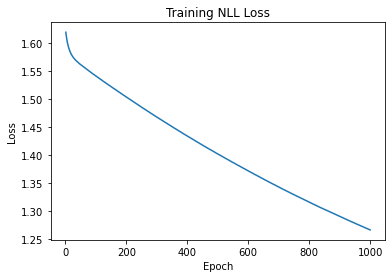

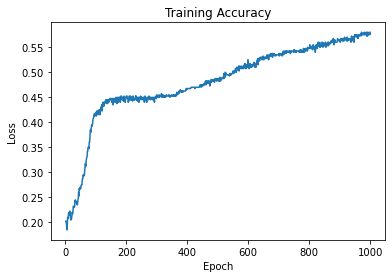

model 2
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  2.  1.  1.  1.  6.  1.  4.  3.  2.]
 [ 0.  0. 11.  0. 13.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  1.  0.  1.  3.  1.  0.  7.]
 [ 0.  0.  7.  0.  0.  0.  4.  2.  0.  8.]
 [16.  0.  0.  0.  0.  0.  2.  0.  0.  0.]]
Factor Vae metric: 
Accuracy: 0.5
Beta Vae metric: 


KeyboardInterrupt: 

In [17]:
models = [model0, model1, model2, model3, model4, model5]
i=1
for model in models:
    print("model "+str(i))
    loss = entanglement_metric_factor_vae(model, data_, 100, 1000)
    print("Factor Vae metric: ")
    print("Accuracy: "+str(1-loss))
    print("Beta Vae metric: ")
    classifier = Classifier()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
    losses, accuracies = entanglement_metric_beta_vae(model, classifier, optimizer, 1000,  data_, 500, 50)
    plot_loss(losses, "NLL Loss")
    plot_loss(accuracies, "Accuracy")
    i+=1

In [11]:
print(data_.factors_names)

(b'color', b'shape', b'scale', b'orientation', b'posX', b'posY')


In [20]:
imgs = latent_transversal(model0,data_[10][0].float(),-3,3,10,7)

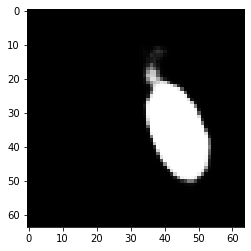

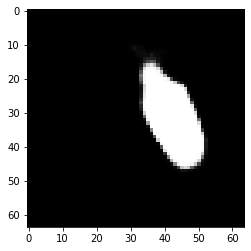

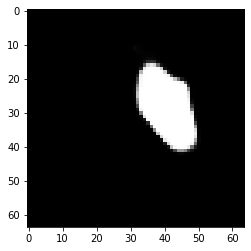

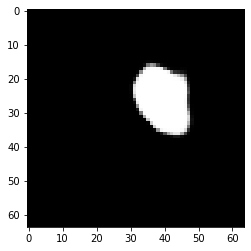

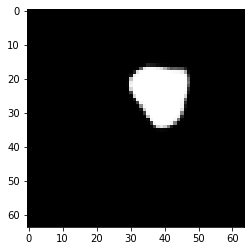

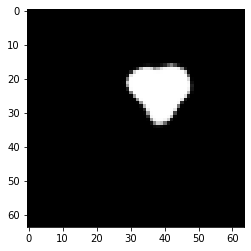

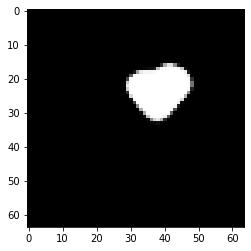

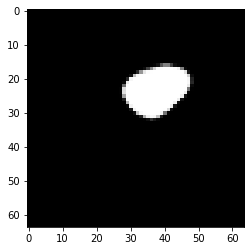

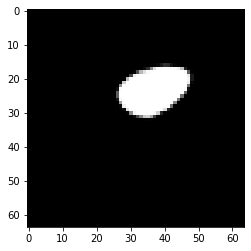

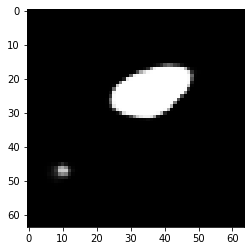

In [21]:
for img in imgs:
    plt.imshow(torch.sigmoid(img.squeeze().detach()), cmap='Greys_r')
    plt.title("")
    plt.show()